# RNN for generating Battery load profiles

The code is structured as follows:
- Imports and definition of some basic parameters
- Simulation model for creating the data
- Datasets using the simulation models
- Shared ANN components
- State Estimator definition and Training
- Classifier definition and Training
- Evaluation
- Additional code for displaying individual created load profiles

Please note:
- The code is set up to use CUDA. Remove the .cuda() calls to run on CPU.
- Batches are created in individual processes.
- To run the evaluation code make sure to install 'jupyter-widgets/jupyterlab-manager' via the command 'jupyter labextension install @jupyter-widgets/jupyterlab-manager'

In [1]:
systems_module_location = "../../simulation"

import logging

# add module location to $PATH if it is missing
import sys
if systems_module_location not in sys.path:
    sys.path.append(systems_module_location)

import os
    
import systems

%pylab inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.autograd as autograd
import torch.optim as optim
import torch.utils.data

from torch.autograd import Variable
from torch.multiprocessing import Manager, Process, Queue
import queue

from tqdm import tqdm_notebook as tqdm

import numpy as np

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(precision=6, suppress=True, linewidth=150)

# Length of a tick in seconds
tick_length = 15 * 60
# number of seconds in a slot
slot_length = 15 * 60

# number of slots in a load profile
slot_count = 4 * 24

# number of slots in a day
slots_per_day = 24 * 60 * 60 / slot_length

## Simulator for creating training data

In [3]:
def battery_random_strategy(time, delta_time, action_idxs, battery):
    return np.random.choice(action_idxs, 1)[0]

class BatterySimulation:

    def __init__(self, battery, battery_strategy):
        self.battery = battery
        self.battery_strategy = battery_strategy
        
        self.actions = battery.get_actions() # dictionary mapping all combinations of actions
        
        self.load_profile = []
        self.infeasibility_slot = -1        
                
        self.records = []
        
        
    def add_record(self, feasible_actions, action_choice, external_input, debugging_info):
        record = {
            # bat_soc
            'state' :   (round(self.battery.get_state_of_charge(), 4),),
            'feasible_actions' : feasible_actions,
            'action_choice' : action_choice,
            'external_input' : external_input,
            'debugging_info' : debugging_info               
        }
        self.records.append(record)
        
    def run(self, tick_length, slot_length, until):
        time = 0
        sum_of_powers = np.array([0., 0.])
        while time < until:
        
            #
            # determine feasible actions
            #

            # battery
            feasible_action_idxs = self.battery.get_feasible_action_idxs(tick_length)

            # choose an action
            action_choice = self.battery_strategy(time, tick_length, feasible_action_idxs, self.battery)
               
            self.add_record(feasible_action_idxs, action_choice, 0, None)
            
            #
            # battery simulation step
            #            
            sum_of_powers[0] += self.battery.state_transition(tick_length, action_choice).el_power
            
            # evaluate feasibility
            if self.infeasibility_slot < 0 and action_choice not in feasible_action_idxs:
                self.infeasibility_slot = time // slot_length

            # generate new slot
            if time % slot_length == slot_length-tick_length:
                # reached end of slot
                self.load_profile.append(sum_of_powers[0] / (slot_length/tick_length))
                # reset sum
                sum_of_powers = np.array([0., 0.])
            
            time += tick_length
            
        self.add_record(None, None, None, None)

## Datasets for state transition and classification tasks

All datasets are generated on the fly using the simulation model defined above.

### Parameters for initializing simulations
The following parameters are used to initialize the simulation (and evaluation):

In [4]:
battery_socs = np.linspace(0, 1, 101)

battery_charging_efficiency = 0.94
battery_discharging_efficiency = 0.94

In [5]:
class BatteryTransitionDataset(torch.utils.data.Dataset):
    '''    
    Generates a dataset for state transition learning    
    '''
    
    def __init__(self, tick_length, slot_length, slot_count, 
                 battery_socs, battery_charging_efficiency, battery_discharging_efficiency):
        self.tick_length = tick_length
        self.slot_length = slot_length
        self.slot_count = slot_count
        
        self.battery_socs = battery_socs
        self.battery_charging_efficiency = battery_charging_efficiency
        self.battery_discharging_efficiency = battery_discharging_efficiency
        
    def set_slot_count(self, slot_count):
        self.slot_count = slot_count
        
    def index_to_parameter_indices(self, index):
        """
        For on the fly parameter mapping
        """
        
        battery_soc = index % len(self.battery_socs)        
        return (battery_soc,)
        
        
    def __len__(self):
        return len(self.battery_socs)
        
    
    def __getitem__(self, index):

        #
        # map index to parameters
        #
        indices = self.index_to_parameter_indices(index)
        
        battery_soc = round(self.battery_socs[indices[0]], 4)
        
        #
        # initialize systems
        #
        battery = systems.Battery(1, 1, 100, battery_soc, self.battery_charging_efficiency, self.battery_discharging_efficiency, 0, 0)
        
        # run simulation to advance states
        simulation = BatterySimulation(battery, battery_random_strategy)
        simulation.run(self.tick_length, self.slot_length, self.slot_count * self.slot_length)
        
        input_one_hot = [] # don't start with [0,0] for this recurrent network with readable states
        for record in simulation.records:
            #print(record)
            if record['action_choice'] != None:
                one_hot = np.zeros(len(simulation.actions))
                one_hot[record['action_choice']] = 1
                input_one_hot.append(one_hot)
        
        return {'input_state': torch.Tensor(simulation.records[0]['state']),
                'input_one_hot': torch.Tensor(input_one_hot),
                'input_external': torch.zeros(self.slot_count).view(-1,1),
                'output_states': torch.Tensor([simulation.records[i+1]['state'] for i in range(self.slot_count)])
               }
    
transition_dataset = BatteryTransitionDataset(tick_length, slot_length, 1, battery_socs, battery_charging_efficiency, battery_discharging_efficiency)

In [6]:
class BatteryClassificationDataset(torch.utils.data.Dataset):
    '''    
    Generates a dataset for classification learning    
    '''
    
    def __init__(self, tick_length, slot_length, battery_socs, battery_charging_efficiency, battery_discharging_efficiency):        
        self.tick_length = tick_length
        self.slot_length = slot_length
        
        self.battery_socs = battery_socs
        self.battery_charging_efficiency = battery_charging_efficiency
        self.battery_discharging_efficiency = battery_discharging_efficiency
        
        #self.weighted_soc_idxs = []
        #for i, soc in enumerate(self.battery_socs):
        #    if soc <= 0.3 or soc >= 0.75:
        #        self.weighted_soc_idxs.append(i)
        #    self.weighted_soc_idxs.append(i)

    def sample_index(self):
        ''' Randomly samples an index for batch creation '''

        return np.random.randint(len(self.battery_socs)) #np.random.choice(self.weighted_soc_idxs, 1)[0]
                
        
    def set_slot_count(self, slot_count):
        self.slot_count = slot_count
        
        
    def index_to_parameter_indices(self, index):
        """
        For on the fly parameter mapping
        index -> indices-tuple (0: battery_soc)
        """
        
        battery_soc = index % len(self.battery_socs)        
        
        return (battery_soc,)
    
        
    def __len__(self):
        return len(self.battery_socs)
        
    
    def __getitem__(self, index):

        #
        # map index to parameters
        #
        indices = self.index_to_parameter_indices(index)
        
        battery_soc = round(self.battery_socs[indices[0]], 4)
        
        #
        # initialize systems
        #
        battery = systems.Battery(1, 1, 100, battery_soc, self.battery_charging_efficiency, self.battery_discharging_efficiency, 0, 0)
        
        # run simulation to advance states
        simulation = BatterySimulation(battery, battery_random_strategy)
        simulation.run(self.tick_length, self.slot_length, self.slot_length)
        
        feasible_actions_one_hot = np.zeros(len(simulation.actions))
        feasible_actions_one_hot[simulation.records[0]['feasible_actions']] = 1
        
        return {'input_state': torch.Tensor(simulation.records[0]['state']), 
                'output': torch.Tensor(feasible_actions_one_hot)}
    
classification_dataset = BatteryClassificationDataset(tick_length, slot_length, battery_socs, battery_charging_efficiency, battery_discharging_efficiency)

## Shared ANN Modules

In [7]:
class GatedLinearLayer(nn.Module):
    
    def __init__(self, size, bias=False):
        super().__init__()
        
        input_size, output_size = size, size
        
        self.result_linear = nn.Linear(input_size, output_size, bias=bias)
        self.result_activation = nn.Tanh()
        self.gate_linear = nn.Linear(input_size, output_size, bias=bias)
        self.gate_activation = nn.Tanh()
        
    def forward(self, input_tensor):
        
        result = self.result_linear(input_tensor)
        result = self.result_activation(result)
        gate = self.gate_linear(input_tensor)
        gate = self.gate_activation(gate)
        
        return result * gate
        
class GatedResidualLinearBlock(nn.Module):
    
    def __init__(self, size, internal_size, bias=False):
        super().__init__()
        
        input_size, output_size = size, size
        
        self.result_linear0 = nn.Linear(input_size, internal_size, bias=bias)
        self.result_activation0 = nn.Tanh()
        self.result_linear1 = nn.Linear(internal_size, internal_size, bias=bias)
        self.result_activation1 = nn.Tanh()
        self.result_linear2 = nn.Linear(internal_size, output_size, bias=bias)
        
        self.gate_linear0 = nn.Linear(input_size, output_size, bias=bias)
        self.gate_activation0 = nn.Tanh()
        self.gate_linear1 = nn.Linear(input_size, output_size, bias=bias)
        self.gate_activation1 = nn.Tanh()
        
    def forward(self, input_tensor):
        
        result = self.result_linear0(input_tensor)
        result = self.result_activation0(result)
        result = self.result_linear1(result)
        result = self.result_activation1(result)
        result = self.result_linear2(result)
        
        gate = self.gate_linear0(input_tensor)
        gate = self.gate_activation0(gate)
        gate = self.gate_linear1(gate)
        gate = self.gate_activation1(gate)
        
        return result * gate + input_tensor
    
class LinearBlock(nn.Module):
    
    def __init__(self, size, bias=False):
        super().__init__()
        
        input_size, output_size = size, size
        
        self.layer_0 = nn.Linear(input_size, output_size, bias=bias)
        self.layer_0_activation = nn.ReLU()
        self.layer_1 = nn.Linear(input_size, output_size, bias=bias)
        self.layer_1_activation = nn.ReLU()
        self.layer_2 = nn.Linear(input_size, output_size, bias=bias)
        self.layer_2_activation = nn.ReLU()
        
    def forward(self, input_tensor):
        
        result = self.layer_0(input_tensor)
        result = self.layer_0_activation(result)
        result = self.layer_1(result)
        result = self.layer_1_activation(result)
        result = self.layer_2(result)
        result = self.layer_2_activation(result)
        
        return result
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, -1, 1)
        m.bias.data.fill_(0.01)

## State Estimator

In [8]:
class StateTransition(nn.Module):
    
    def __init__(self, input_size, network_width, state_size):
        super().__init__() 
        
        self.state_size = state_size
        self.input_size = input_size
        self.network_width = network_width
        
        self.tr0 = nn.Linear(input_size, network_width, bias=True)
        self.tr1 = LinearBlock(network_width, True)
        self.tr1g = LinearBlock(network_width, True)
        self.tr2 = LinearBlock(network_width, True)
        self.tr2g = LinearBlock(network_width, True)
        self.tr3 = LinearBlock(network_width, True)
        self.tr3g = LinearBlock(network_width, True)
        self.tr4 = LinearBlock(network_width, True)
        self.tr4g = LinearBlock(network_width, True)
        self.tr5 = LinearBlock(network_width, True)
        self.tr5g = LinearBlock(network_width, True)
        self.tr6 = nn.Linear(network_width, state_size, bias=True)
    
    
    def forward(self, input_state, input_one_hot, input_external, depth=sys.maxsize):
                    
        input_tensor = torch.cat((input_state, input_one_hot, input_external), dim=1)
        
        #print(input_tensor.size())
        
        state = self.tr0(input_tensor)
        if depth > 0:
                state = self.tr1(state) * self.tr1g(state) + state
        if depth > 1:
                state = self.tr2(state) * self.tr2g(state) + state
        if depth > 2:
                state = self.tr3(state) * self.tr3g(state) + state
        if depth > 3:
                state = self.tr4(state) * self.tr4g(state) + state
        if depth > 4:
                state = self.tr5(state) * self.tr5g(state) + state      
                
        state = self.tr6(state) + input_state
        
        return state
    
    def initialize_block_weigths(self, block, init_function):
        if block == 1:
            self.tr1.apply(init_function)
            self.tr1g.apply(init_function)
        elif block == 2:
            self.tr2.apply(init_function)
            self.tr2g.apply(init_function)
        elif block == 3:
            self.tr3.apply(init_function)
            self.tr3g.apply(init_function)
        elif block == 4:
            self.tr4.apply(init_function)
            self.tr4g.apply(init_function)
        elif block == 5:
            self.tr5.apply(init_function)
            self.tr5g.apply(init_function)

#transition.apply(init_weights) <- problems with NaNs, maybe caused by MSELoss?

In [9]:
transition_batch_processes = []

In [10]:
def create_transition_batch(batch_queue, batch_size, input_queue, transition_dataset):
    ''' Function used by process to create batches. Batches are created according to the parameters 
    given in the input_queue which specifies the number of unfolding steps. '''
    while True:
        # set the number of unfolding steps used for creating the next batch      
        transition_dataset.set_slot_count(input_queue.get())
        
        # draw initial states
        indices = np.random.randint(len(transition_dataset), size=(batch_size), dtype='int64')
        
        # create batch
        batch = {}
        for idx in indices:    
            for key, value in transition_dataset[idx].items():
                if key in batch:
                    batch[key] = torch.cat([batch[key], value.unsqueeze(0)], dim=0)
                else:
                    batch[key] = value.unsqueeze(0)
        batch_queue.put(batch)

In [ ]:
# loss function
transition_loss_function = nn.MSELoss().cuda()
target_function_weights = torch.Tensor([20,1,1,20,80,10,10,1,1]).cuda()

# training parameters
batch_size=32
training_batch_count = 150001
training_summary_at = 1000

# evaluation
evaluation_at = 10000
evaluation_batch_count = 1000
evaluation_on_low_training_loss = True
best_model_loss = 0.1

# regularization
l1_crit = nn.L1Loss(reduction='sum').cuda()
reg_loss_factor = 1/100000000 #1/10000000

# learning rate adaptation
learning_rate_initialization = 1e-3
learning_rate_loss_factor = 1/1#0#00000
learning_rate_decay_after = 50000
learning_rate_decay_at = 10000
learning_rate_decay_factor = 1/2

# modell unfolding
unfolding_after = 1000
unfolding_at = 1000
unfolding_delta = 1
unfolding_share = 0
unfolding_max_steps = 4
single_step_share = 1
unfolding_share = unfolding_share / (unfolding_share + single_step_share)

# pretraining
use_pretraining = False
pretraining_initial_depth = 1
pretraining_max_depth = 3
pretraining_expand_depth_at = 30000

# model parameters
model_input_size = 1 + 1 + 201 
model_width = 64
model_output_size = 1
model_depth = 2 # pretrain overrides this parameter

#
# set up
#
training_run = str(int(time.time()))
training_out = "transition/" + training_run

# create output directory
if not os.path.exists(training_out):
    os.makedirs(training_out)

# set up logger
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("{0}/info.log".format(training_out)),
        logging.StreamHandler()
    ])

logging.info("batch_size: %d"%batch_size)
logging.info("learning_rate_initialization: %f, learning_rate_loss_factor: %f, learning_rate_decay_after: %d, learning_rate_decay_at: %d, learning_rate_decay_factor: %f"%
            (learning_rate_initialization, learning_rate_loss_factor, learning_rate_decay_after, learning_rate_decay_at, learning_rate_decay_factor))
logging.info('weigths: %s'%str(target_function_weights))
logging.info('regularization factor: %.16f'%reg_loss_factor)
logging.info("unfolding_after: %d, unfolding_at: %d, unfolding_delta: %d, unfolding_share: %f"%(unfolding_after, unfolding_at, unfolding_delta, unfolding_share))

for model_number in range(10):

    learning_rate = learning_rate_initialization
    
    # queue holding batches
    multiprocessing_manager = Manager()
    transition_batch_queue = multiprocessing_manager.Queue(10)
    transition_input_queue = multiprocessing_manager.Queue(20)

    # stop the batch creating process if it is already running
    for process in transition_batch_processes:
        process.terminate()
        process.join() # kill zombie process

    # start batch creating processes
    for i in range(4):
        process = Process(target=create_transition_batch, 
                          args=(transition_batch_queue, batch_size, transition_input_queue, transition_dataset))
        process.start()
        transition_batch_processes.append(process)


    transition = StateTransition(model_input_size, model_width, model_output_size).cuda()
    logging.info('---------------------------------')
    if use_pretraining:
        estimator_depth = pretraining_initial_depth
        logging.info("Training model #%d: (%d, %d, %d) @ %d to %d, step at %d"%(model_number, model_input_size, 
                                                          model_width, model_output_size,
                                                          pretraining_initial_depth, pretraining_max_depth, pretraining_expand_depth_at))
    
    else:
        estimator_depth = model_depth
        logging.info("Training model #%d: (%d, %d, %d) @ %d"%(model_number, model_input_size, 
                                                          model_width, model_output_size,
                                                          estimator_depth))
    
    transition_solver = optim.Adam(transition.parameters(), lr=5e-3)

    worst_loss = -1
    worst_loss_unfolding = -1
    worst_est = None
    worst_target = None
    
    unfolding_limit= 2
    n_unfolding = 0
    n_single_step = 0    

    force_evaluation = False
    for batch_number in range(training_batch_count):

        # create input for the batch generation process
        try:
            while transition_input_queue.full() == False:
                # determine number of steps
                if batch_number > unfolding_after and np.random.random() < unfolding_share:
                    number_training_steps = unfolding_limit + 1 #np.random.randint(2, unfolding_limit+1)
                else:
                    number_training_steps = 1
                transition_input_queue.put_nowait(number_training_steps)
        except queue.Full:
            pass

        try:
            batch = transition_batch_queue.get()
        except FileNotFoundError:
            batch = transition_batch_queue.get()

        state = batch['input_state'].cuda()
        batch['input_one_hot'] = batch['input_one_hot'].cuda()
        batch['input_external'] = batch['input_external'].cuda()

        
        transition_loss = torch.zeros(1).cuda()
        successful_iterations = 0
        for i in range(min(unfolding_limit, batch['input_one_hot'].size(1))):
            new_state = transition(state, 
                                   batch['input_one_hot'][:,i], 
                                   batch['input_external'][:,i].view(-1,1), 
                                   estimator_depth)

            if torch.isnan(new_state).any():
                logging.warning('NaN')
                unfolding_limit = max(unfolding_limit - unfolding_delta, 2)
                break        

            state = new_state
            target = batch['output_states'][:,i].cuda()
            successful_iterations = i + 1
            
            transition_loss += transition_loss_function(state * target_function_weights, 
                                                   target * target_function_weights)

        if successful_iterations > 1:
            n_unfolding += 1
        else:
            n_single_step += 1
            
        transition_loss /= successful_iterations
        
        est = state                
        #transition_loss += transition_loss_function(est * target_function_weights, 
        #                                           target * target_function_weights)

        # regularization
        reg_loss = torch.zeros(1).cuda()
        for param in transition.parameters():
            reg_loss += l1_crit(param, torch.zeros(param.size()).cuda())
        transition_loss =  transition_loss + reg_loss * reg_loss_factor

        if transition_loss.data > worst_loss:
            worst_loss = transition_loss.data
            worst_loss_unfolding = batch['input_one_hot'].size(1)-1
            worst_est = est
            worst_target = target

        # training step
        transition_solver.zero_grad()
        transition_loss.backward(retain_graph=True)    
        
        # compute sum of gradient norms for summary
        grad_norm_sum = 0
        if batch_number % training_summary_at == 0:            
            for p in transition.parameters():
                grad_norm_sum += torch.norm(p.grad.data)

        # clip grad norms
        nn.utils.clip_grad_norm_(transition.parameters(), 0.1)
        transition_solver.step()
    
        # show training progress
        if batch_number % training_summary_at == 0 and batch_number > 0:
            
            logging.info('---------------------------------')
            logging.info('Summary:')
            logging.info('Batch %d, worst loss %f of %d batches (incl. reg.) (unfolding: %d), learning rate %f @est.-depth %d'%
                         (batch_number, worst_loss, training_summary_at, worst_loss_unfolding, learning_rate, estimator_depth))
            
            logging.info("Regularization: %f * %.10f = %.10f loss"%(reg_loss, reg_loss_factor, reg_loss * reg_loss_factor))
            logging.info('unfolding %d, single step %d'%(n_unfolding, n_single_step))

            if (reg_loss * reg_loss_factor).data * 10 > worst_loss:                
                logging.info('reducing reg_loss_factor')
                reg_loss_factor *= 0.1
                
            logging.info('Sum of grad norms of most recent batch: %f'%grad_norm_sum)
                                
            # do learn rate adaption
            learning_rate = min(learning_rate_initialization, max(1e-16, min(float(worst_loss)*learning_rate_loss_factor, learning_rate)))
            for param_group in transition_solver.param_groups:
                param_group['lr'] = learning_rate
            
            if worst_loss < best_model_loss:
                force_evaluation = evaluation_on_low_training_loss
            
            worst_loss = -1
            logging.info('---------------------------------')
            
        # conduct model evaluation    
        if force_evaluation or (batch_number % evaluation_at == 0 and batch_number > 0):
            force_evaluation = False            

            # do evaluation
            transition.eval()

            for evaluation_batch_number in range(evaluation_batch_count):
                
                # create input for the batch generation process
                try:
                    while transition_input_queue.full() == False:
                        number_training_steps = 1    
                        transition_input_queue.put_nowait(number_training_steps)
                except queue.Full:
                    pass

                try:
                    batch = transition_batch_queue.get()
                except FileNotFoundError:
                    batch = transition_batch_queue.get()
                
                state = batch['input_state'].cuda()
                batch['input_one_hot'] = batch['input_one_hot'].cuda()
                batch['input_external'] = batch['input_external'].cuda()
                
                est = transition(state, 
                                   batch['input_one_hot'][:,0], 
                                   batch['input_external'][:,0].view(-1,1), 
                                   estimator_depth)
                target = batch['output_states'][:,0].cuda()
                transition_loss = transition_loss_function(est * target_function_weights, 
                                                           target * target_function_weights)

                if transition_loss.data > worst_loss:
                    worst_loss = transition_loss.data
                    worst_est = est
                    worst_target = target

            # finished
            transition.train()

            logging.info('---------------------------------')
            logging.info('Evaluation:')
            logging.info('Batch %d, worst loss %f of %d batches (without reg.) @est.-depth %d'%
                 (batch_number, worst_loss, evaluation_batch_count, estimator_depth))

            if worst_loss < best_model_loss and batch_number > 1:                
                best_model_loss = worst_loss
                # save modell
                file_name = training_out + '/' + str(int(time.time())) + '_' + str(model_number) + \
                            '_transition_' + str(batch_number) + '.pth'
                logging.info("New best loss %f, saved to file %s"%(worst_loss,file_name))
                torch.save(transition.state_dict(), file_name)

                logging.info('Target')
                logging.info(worst_target.cpu().numpy())
                logging.info('Estimator output')
                logging.info(worst_est.detach().cpu().numpy())

            worst_loss = -1
            logging.info('---------------------------------')    
        
        # expand model depth when pretraining 
        if use_pretraining and batch_number > 0 and batch_number % pretraining_expand_depth_at == 0:
            if estimator_depth < pretraining_max_depth:
                estimator_depth += 1
                transition.initialize_block_weigths(estimator_depth, init_weights)
        
        # adapt learning rate            
        if batch_number > learning_rate_decay_after and batch_number % learning_rate_decay_at == 0:
            learning_rate = learning_rate * learning_rate_decay_factor
            
        # adapt unfolding
        if batch_number > unfolding_after and batch_number % unfolding_at == 0:
            unfolding_limit = min(unfolding_limit + unfolding_delta, min(unfolding_max_steps, slot_count-1))
            
    # finished training
    file_name = training_out + '/' + str(int(time.time())) + '_' + str(model_number) + '_transition_final.pth'
    logging.info("Finished training, saved to file %s"%(file_name))
    torch.save(transition.state_dict(), file_name)


## Classifier

In [12]:
class Classifier(nn.Module):
    
    def __init__(self, state_size, network_width, output_size):
        super().__init__()
        
        self.state_size = state_size
        self.network_width = network_width
        self.output_size = output_size
        
        self.cl0 = nn.Linear(state_size, network_width)
        self.cl1 = LinearBlock(network_width, bias=True)
        self.cl2 = LinearBlock(network_width, bias=True)
        self.cl3 = LinearBlock(network_width, bias=True)
        self.cl4 = LinearBlock(network_width, bias=True)
        self.cl5 = LinearBlock(network_width, bias=True)
        
        self.clbn0 = nn.BatchNorm1d(network_width)
        self.clbn1 = nn.BatchNorm1d(network_width)
        
        self.cl0o = nn.Linear(network_width, output_size, bias=True)
        self.cl1o = nn.Linear(network_width, output_size, bias=True)
        self.cl2o = nn.Linear(network_width, output_size, bias=True)
        self.cl3o = nn.Linear(network_width, output_size, bias=True)
        self.cl4o = nn.Linear(network_width, output_size, bias=True)
        self.cl5o = nn.Linear(network_width, output_size, bias=True)
             
        
    def forward(self, input_state, depth=sys.maxsize):
        #input_power = input_power.unsqueeze(1)
         
        out = self.cl0(input_state)
        #out = self.cl0a(out)
        if depth > 0:
            out = self.cl1(out)
        if depth > 1:
            out = self.cl2(out)
        if depth > 2:
            out = self.cl3(out)
        if depth > 3:
            out = self.cl4(out)
        if depth > 4:
            out = self.cl5(out)
            
            
        if depth == 0:
            out = self.cl0o(out)
        elif depth == 1:
            out = self.cl1o(out)
        elif depth == 2:
            out = self.cl2o(out)
        elif depth == 3:
            out = self.cl3o(out)
        elif depth == 4:
            out = self.cl4o(out)
        else:
            out = self.cl5o(out)
            
        return out
    
    def initialize_block_weigths(self, block, init_function):
        if block == 1:
            self.cl1.apply(init_function)
            self.cl1o.apply(init_function)
        elif block == 2:
            self.cl2.apply(init_function)
            self.cl2o.apply(init_function)
        elif block == 3:
            self.cl3.apply(init_function)
            self.cl3o.apply(init_function)
        elif block == 4:
            self.cl4.apply(init_function)
            self.cl4o.apply(init_function)
        elif block == 5:
            self.cl5.apply(init_function)
            self.cl5o.apply(init_function)

In [13]:
classification_batch_processes = []

In [14]:
def create_classification_batch(batch_queue, batch_size, classification_dataset):
    ''' Function used by process to create batches '''
    while True:
        # draw initial states
        indices = [classification_dataset.sample_index() for i in range(batch_size)]
        
        # create batch
        batch = {}
        for idx in indices:    
            for key, value in classification_dataset[idx].items():
                if key in batch:
                    batch[key] = torch.cat([batch[key], value.unsqueeze(0)], dim=0)
                else:
                    batch[key] = value.unsqueeze(0)
        batch_queue.put(batch)

In [ ]:
# loss function
classifier_loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1]*201)).cuda() #nn.MultiLabelSoftMarginLoss()

#training parameters
batch_size=32
training_batch_count = 250001 #100001
training_summary_at = 1000

# regularization
l1_crit = nn.L1Loss(reduction='sum').cuda()
reg_loss_factor = 1/1000 #1/10000

# evaluation
evaluation_at = 10000
evaluation_batch_count = 1000
evaluation_on_low_training_loss = True

# learning rate adaptation
learning_rate_initialization = 5e-3
learning_rate_loss_factor = 1/100#00000
learning_rate_decay_after = 30000
learning_rate_decay_at = 10000
learning_rate_decay_factor = 1/2

# pretraining
use_pretraining = False
pretraining_initial_depth = 1
pretraining_max_depth = 2
pretraining_expand_depth_at = 30000

# model parameters
model_input_size = 1
model_width = 64
model_output_size = 201
model_depth = 1 # pretraining overrides this parameter

best_model_loss = 0.06

#
# set  up
#
training_run = str(int(time.time()))
training_out = "classifier/" + training_run

# create output directory
if not os.path.exists(training_out):
    os.makedirs(training_out)

# set up logger
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("{0}/info.log".format(training_out)),
        logging.StreamHandler()
    ])

logging.info("learning_rate_initialization: %f, learning_rate_loss_factor: %f, learning_rate_decay_after: %d, learning_rate_decay_at: %d, learning_rate_decay_factor: %f"%
            (learning_rate_initialization, learning_rate_loss_factor, learning_rate_decay_after, learning_rate_decay_at, learning_rate_decay_factor))
logging.info('regularization factor: %.10f'%reg_loss_factor)

for model_number in range(10):
    
    learning_rate = learning_rate_initialization
    
    # queue holding batches
    multiprocessing_manager = Manager()
    classification_batch_queue = multiprocessing_manager.Queue(10)

     # stop the batch creating process if it is already running
    for process in classification_batch_processes:
        process.terminate()
        process.join() # kill zombie process

    # start batch creating processes
    for i in range(4):
        process = Process(target=create_classification_batch, 
                          args=(classification_batch_queue, batch_size, classification_dataset))
        process.start()
        classification_batch_processes.append(process)

    
    classifier = Classifier(model_input_size, model_width, model_output_size).cuda()
    classifier.apply(init_weights)
    logging.info('---------------------------------')
    if use_pretraining:    
        classifier_depth = pretraining_initial_depth
        logging.info("Training model #%d: (%d, %d, %d) @ %d to %d, step at %d"%(model_number, model_input_size, 
                                                          model_width, model_output_size,
                                                          pretraining_initial_depth, pretraining_max_depth, pretraining_expand_depth_at))
    
    else:
        classifier_depth = model_depth
        logging.info("Training model #%d: (%d, %d, %d) @ %d"%(model_number, model_input_size, 
                                                          model_width, model_output_size,
                                                          classifier_depth))
    
    classifier_solver = optim.Adam(classifier.parameters(), lr=1e-3)
    
    worst_loss = -1
    worst_est = None
    worst_target = None

    force_evaluation = False
    for batch_number in range(training_batch_count):
        
        batch = classification_batch_queue.get()
        
        input_state = batch['input_state'].cuda()
        out = classifier(input_state, classifier_depth)

        target = batch['output'].cuda()
        
        # {0,1} -> {0.01. 0.99}
        target = (target * 49 + 0.5) / 50 # 9 ... / 10 for {0.05, 0.95}
        
        classifier_loss = classifier_loss_function(out, target)
        
        reg_loss = 0
        for param in classifier.parameters():
            reg_loss += l1_crit(param, torch.zeros(param.size()).cuda())
            
        classifier_loss += reg_loss * reg_loss_factor
            
        if classifier_loss.data > worst_loss:
            worst_loss = classifier_loss.data
            worst_est = out
            worst_target = target

        classifier_solver.zero_grad()
        classifier_loss.backward(retain_graph=True)    
        
        
        # compute sum of gradient norms for summary
        grad_norm_sum = 0
        if batch_number % training_summary_at == 0:            
            for p in classifier.parameters():
                grad_norm_sum += torch.norm(p.grad.data)
                
        nn.utils.clip_grad_norm_(classifier.parameters(), 0.1)
        classifier_solver.step()
            
        # show training progress
        if batch_number % training_summary_at == 0 and batch_number > 0:
            
            logging.info('---------------------------------')
            logging.info('Summary:')
            logging.info('Batch %d, worst loss %f (incl. reg.) of %d batches, learning rate %f @cl.-depth %d'%
                         (batch_number, worst_loss, training_summary_at, learning_rate, classifier_depth))
            
            logging.info("Regularization: %f * %.10f = %.10f"%(reg_loss, reg_loss_factor, reg_loss * reg_loss_factor))
            
            if (reg_loss * reg_loss_factor).data * 10 > worst_loss:
                logging.info('reducing reg_loss_factor')
                reg_loss_factor *= 0.1
                
            logging.info('Sum of grad norms: %f'%grad_norm_sum)
                            
            # do learn rate adaption
            learning_rate = min(learning_rate_initialization, max(1e-16, min(worst_loss*learning_rate_loss_factor, learning_rate)))
            for param_group in classifier_solver.param_groups:
                param_group['lr'] = learning_rate
            
            if worst_loss < best_model_loss:
                force_evaluation = evaluation_on_low_training_loss
            
            worst_loss = -1
            logging.info('---------------------------------')
            
        # conduct model evaluation    
        if force_evaluation or (batch_number % evaluation_at == 0 and batch_number > 0):
            force_evaluation = False

            # do evaluation
            classifier.eval()

            for evaluation_batch_number in range(evaluation_batch_count):
                batch = classification_batch_queue.get()

                input_state = batch['input_state'].cuda()
                out = classifier(input_state, classifier_depth)
                target = batch['output'].cuda()
                
                # {0,1} -> {0.01. 0.99}
                target = (target * 49 + 0.5) / 50 # 9 ... / 10 for {0.05, 0.95}
                
                classifier_loss = classifier_loss_function(out, target)

                if classifier_loss.data > worst_loss:
                    worst_loss = classifier_loss.data
                    worst_est = out
                    worst_target = target

            # finished
            classifier.train()

            logging.info('---------------------------------')
            logging.info('Evaluation:')
            logging.info('Batch %d, worst loss %f (without reg.) of %d batches @cl.-depth %d'%
                 (batch_number, worst_loss, evaluation_batch_count, classifier_depth))

            if worst_loss < best_model_loss and batch_number > 0:                
                best_model_loss = worst_loss
                # save modell
                file_name = training_out + '/' + str(int(time.time())) + '_' + str(model_number) + \
                            '_classifier_' + str(batch_number) + '.pth'
                logging.info("New best loss %f, saved to file %s"%(worst_loss,file_name))
                torch.save(classifier.state_dict(), file_name)

                logging.info('Target')
                logging.info(worst_target.cpu().numpy())
                logging.info('Classifier output')
                logging.info(torch.sigmoid(worst_est.detach()).cpu().numpy())

            worst_loss = -1
            logging.info('---------------------------------')                    
        
        # expand model depth when pretraining 
        if use_pretraining and batch_number > 0 and batch_number % pretraining_expand_depth_at == 0:
            if classifier_depth < pretraining_max_depth:
                classifier_depth += 1
                classifier.initialize_block_weigths(classifier_depth, init_weights)
        
        # adapt learning rate
        if batch_number > learning_rate_decay_after and batch_number % learning_rate_decay_at == 0:
            learning_rate = learning_rate * learning_rate_decay_factor
                                     
    # finished training
    file_name = training_out + '/' + str(int(time.time())) + '_' + str(model_number) + '_classifier_final.pth'
    logging.info("Finished training, saved to file %s"%(file_name))
    torch.save(classifier.state_dict(), file_name)

## Evaluation

### Set up the evaluation

In [17]:
# load models and set evaluation mode

# state transition
transition = StateTransition(1 + 1 + 201, 64, 1)
transition.load_state_dict(torch.load('transition/1552984806_0.000001/1552989898_1_transition_80000.pth'))
estimator_depth = 2 

transition.eval()

# classifier
classifier = Classifier(1, 64, 201) #128, 402)
classifier.load_state_dict(torch.load('classifier/1552933539_0.057/1552965517_6_classifier_160000.pth'))  
classifier_depth = 1

classifier.eval()
pass

In [18]:
def generate_and_evaluate_load_profile(battery_soc, battery_charging_efficiency, battery_discharging_efficiency, 
                  series_length, slot_length, tick_length, 
                  buffers, confidence,
                  transition, estimator_depth, classifier, classifier_depth, state_mapping):
    '''
    
    generates load profiles using the ANNs and evaluates the result.
    
    State post-processing:
        - discretization
    
    '''        
    
    # bat_soc
    current_state = torch.Tensor([battery_soc]).unsqueeze(0)
    
    buffer = torch.Tensor([0]).unsqueeze(0)
    
    # generate data
    generated_states = []    
    generated_data = None
    action_history = []
    for i in range(series_length):
        generated_states.append(current_state.data.numpy()[0])
        
        # classify
        out = classifier(current_state + buffer, classifier_depth)
        if generated_data is None:
            generated_data = out
        else:
            generated_data = torch.cat((generated_data, out), dim = 0)                
            
        # choose action
        feasible_actions = np.where(torch.sigmoid(out.squeeze()).data.numpy() >= confidence)[0]
        if len(feasible_actions) > 0:
            action = np.random.choice(feasible_actions, 1)[0]
        else:
            action = np.argmax(torch.sigmoid(out.squeeze()).data.numpy())
            #print('WARNING: all actions infeasible, defaulting to %d'%action)
        
        action_history.append(action)
        
        action_one_hot = np.zeros(out.size(1))
        action_one_hot[action] = 1
        input_one_hot = torch.Tensor(action_one_hot).view(1,-1)
        input_external = torch.Tensor([0]).view(1,-1)        

        current_state = transition(current_state, input_one_hot, input_external, estimator_depth)
        
        #
        # <state post-processing>
        #
        # (discretization)
        #
        current_state[:,0] = torch.Tensor([state_mapping['discrete_socs'][np.digitize(current_state[:,0].detach().numpy(), 
                                                                                      state_mapping['discrete_socs_bins'])]]).unsqueeze(0)
        #
        # </state post-processing>
        #

    # test if generated profile is feasible
    
    def predetermined_strategy(time, delta_time, action_idxs, battery):
        return action_history[time // slot_length]
    
    battery = systems.Battery(1, 1, 100, battery_soc, battery_charging_efficiency, battery_discharging_efficiency, 0, 0)

    # run simulation
    simulation = BatterySimulation(battery, predetermined_strategy)
    simulation.run(tick_length, slot_length, series_length * slot_length)
    
    return [simulation.infeasibility_slot, np.array(simulation.load_profile), generated_states, generated_data, simulation.records]

In [19]:
np.random.seed(1924)

confidence = 0.95

#
# Elements of the state are discretized
#
state_mapping = {
    # discretization
    'discrete_socs': np.linspace(0, 1, 1001)
}

state_mapping.update({
    'discrete_socs_bins': [(a + b) / 2 for a, b in zip(state_mapping['discrete_socs'][:-1], state_mapping['discrete_socs'][1:])]
})
    
# number of threads used for simulation
simulation_thread_count = 1 # (more than 1 is slower)
# number of simulations to run
simulation_count = 1000

# set up initial states for the simulation runs
force_replace = False

# don't apply here
buffers = {'min_staying_time': (0,0), 'min_charge':0, 'max_charge':0} #(SLOT_LENGTH, SLOT_LENGTH),

battery_soc_choices = np.random.choice(battery_socs, simulation_count, replace=(simulation_count>len(battery_socs) or force_replace))

tasks = [{'battery_soc': battery_soc_choices[i], 
          'battery_charging_efficiency': battery_charging_efficiency, 
          'battery_discharging_efficiency': battery_discharging_efficiency, 
          'series_length': slot_count,
          'tick_length': tick_length,
          'slot_length': slot_length,
          'buffers': buffers,
          'confidence': confidence,
          'transition': transition,
          'estimator_depth': estimator_depth,
          'classifier': classifier,
          'classifier_depth': classifier_depth,
          'state_mapping': state_mapping
         } for i in range(simulation_count)]

### Perform the evaluation

In [20]:
# perform evaluation

# !!!
# Attention: For reproducible results make sure to run the previous code block before running this block
# !!!


# !!!
# Attention: Code is not optimized for multiprocessing! This is faster than using a multiprocessing pool.
#
# From the pytorch documentation: "Sharing CUDA tensors between processes is supported only in Python 3, using a spawn or forkserver start methods."
#
# On Unix "fork" is standard. Options "spawn" and "forkserver"  didn't work in jupyter lab.
# !!!

results = []
with tqdm(total=simulation_count) as pbar:
    for task in tasks:
        results.append(generate_and_evaluate_load_profile(**task))
        pbar.update(1)

### Display results

Generated 983 feasible profiles
Slot of infeasibility:


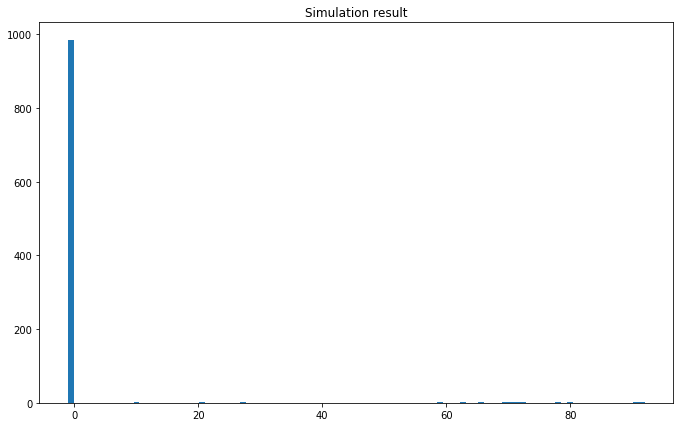

Infeasible profile indices:
[ 93 137 173 358 426 471 567 638 644 679 717 725 848 849 851 866 889]


In [21]:
hist_data = [results[i][0] for i in range(len(results))]
print('Generated %d feasible profiles'%sum([i<0 for i in hist_data]))

print('Slot of infeasibility:')
fig = figure(figsize=(25,7))
fig.set_facecolor('white')
ax = subplot(121)
ax.set_title('Simulation result')
ax.hist(hist_data, 97)
plt.show()

print('Infeasible profile indices:')
print(np.array([i for i in range(len(hist_data)) if hist_data[i]>=0]))

In [22]:
#print('buffers %s'%str(buffers)) # don't apply
print('with confidence %f'%(confidence))

false_positives = 0
false_negatives = 0
total_number = 0

for result in results:
    simulated_data = []
    for i in range(slot_count):
        slot_data = np.zeros(len(result[3][0]))
        slot_data[result[-1][i]["feasible_actions"]] = 1
        simulated_data.append(slot_data)
    simulated_data = np.array(simulated_data)
    difference = (torch.sigmoid(result[3]) >= confidence).data.numpy().round() - simulated_data
    false_positives += sum(difference > 0)
    false_negatives += sum(difference < 0)
    total_number += len(result[3]) * len(result[3][0])

print('false positives: %d, %f'%(false_positives, false_positives/total_number))
print('false negatives: %d, %f'%(false_negatives, false_negatives/total_number))
print('correctly classified: %d, %f'%(total_number-false_positives-false_negatives, (total_number-false_positives-false_negatives)/total_number))

with confidence 0.950000
false positives: 3018, 0.000156
false negatives: 80416, 0.004167
correctly classified: 19212566, 0.995676


### Simulation details

The following code can be used to look into the details of an individual simulation run. Simply specify the idx at the beginning of the next code block.

The plots show the feasibility of actions for each time slot. Dark areas are infeasible actions. Please keep in mind, that the feasibility of actions depends on the state which in turn depends on the load profile, i.e., the performed actions. The respective load profile is plotted in red.

Initial state
{'state': (0.84,), 'feasible_actions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168], 'action_choice': 66, 'external_input': 0, 'debugging_info': None}
id 0, soc 0.840000, infeasibility @-1


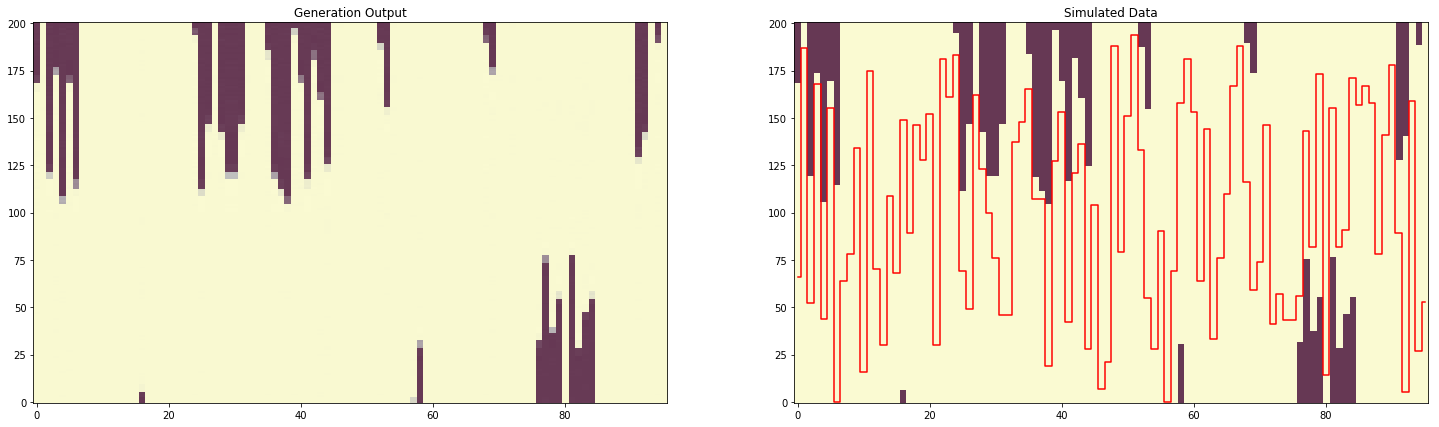

Generation Delta


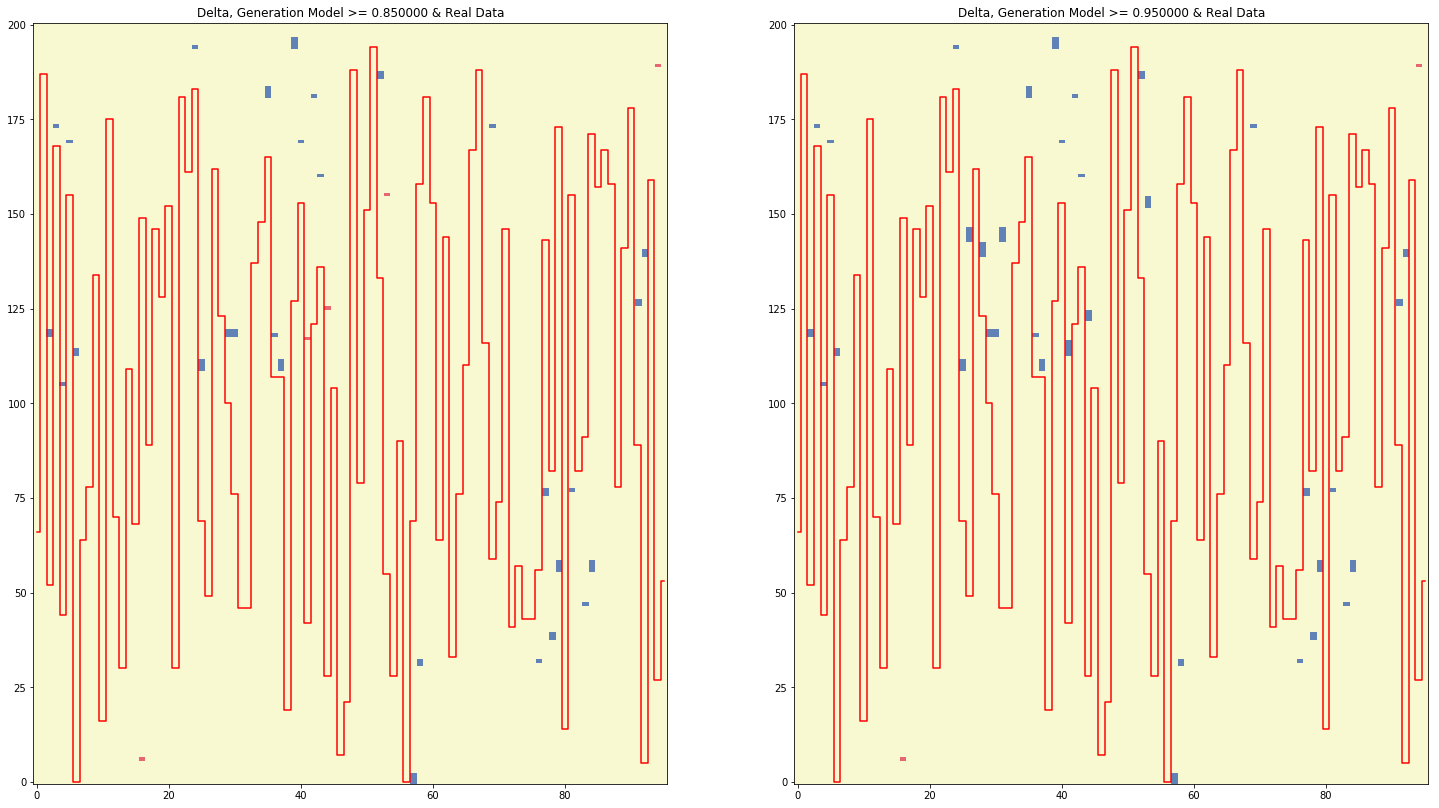

In [25]:
# index of simulation run
idx = 0

# confidence used for plotting
plot_confidence = 0.85

# plot design
standard_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('standard', ['#663854', '#BEBEBE', '#FAFAD2'])
delta_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('delta', ['#6082B6', '#FAFAD2', '#E66771'])

# dataset parameters
number_of_actions = len(results[idx][3][0])

print('Initial state')
print(results[idx][-1][0])

actions = [results[idx][-1][i]["action_choice"] for i in range(slot_count)]

generated_data = results[idx][3]
simulated_data = []
for i in range(slot_count):
    slot_data = np.zeros(number_of_actions)
    slot_data[results[idx][-1][i]["feasible_actions"]] = 1
    simulated_data.append(slot_data)
simulated_data = np.array(simulated_data)

infeasible_at = results[idx][0]
print('id %d, soc %f, infeasibility @%d'%(idx, results[idx][-1][0]["state"][0], infeasible_at))

fig = figure(figsize=(25,7))
fig.set_facecolor('white')

ax = subplot(121)
ax.set_title('Generation Output')
ax.imshow(torch.sigmoid(generated_data).data.numpy().transpose(), cmap=standard_cmap, origin='lower', aspect='auto', vmin=0, vmax=1)

ax2 = subplot(122)
ax2.set_title('Simulated Data')
ax2.step(range(0,96), actions, 'r', where='mid')
ax2.imshow(simulated_data.transpose(), cmap=standard_cmap, origin='lower', aspect='auto', vmin=0, vmax=1)

plt.show()

print('Generation Delta')
fig = figure(figsize=(25,14))
fig.set_facecolor('white')

ax = subplot(121)
ax.set_title('Delta, Generation Model >= %f & Real Data'%plot_confidence)
ax.imshow((torch.sigmoid(generated_data) >= plot_confidence).data.numpy().round().transpose() - simulated_data.transpose(), cmap=delta_cmap, origin='lower', aspect='auto', vmin=-1, vmax=1)
ax.step(range(0,96), actions, 'r', where='mid')

ax2 = subplot(122)
ax2.set_title('Delta, Generation Model >= %f & Real Data'%confidence)
ax2.imshow((torch.sigmoid(generated_data) >= confidence).data.numpy().round().transpose() - simulated_data.transpose(), cmap=delta_cmap, origin='lower', aspect='auto', vmin=-1, vmax=1)
ax2.step(range(0,96), actions, 'r', where='mid')

plt.show()

In [26]:
start_slot = infeasible_at
end_slot = start_slot + 1

#start_slot = 0
#end_slot = 10

np.set_printoptions(suppress=True)

for i in range(start_slot, end_slot+1):
    print('slot %d'%i)
    print('Sim:',end=" ")
    print(results[idx][-1][i])
    print('Gen:',end=" ")
    print(np.array2string(np.around(results[idx][2][i],4), separator=', '))
    print(torch.sigmoid(results[idx][3][i]))
    print('Rating of chosen action:',end=" ")
    print(torch.sigmoid(results[idx][3][i][results[idx][-1][i]['action_choice']]))

slot -1
Sim: {'state': (0.4728,), 'feasible_actions': None, 'action_choice': None, 'external_input': None, 'debugging_info': None}
Gen: [0.595]
tensor([0.9900, 0.9899, 0.9899, 0.9899, 0.9902, 0.9901, 0.9901, 0.9900, 0.9900,
        0.9900, 0.9900, 0.9900, 0.9900, 0.9900, 0.9901, 0.9901, 0.9901, 0.9900,
        0.9900, 0.9899, 0.9899, 0.9899, 0.9901, 0.9900, 0.9899, 0.9899, 0.9900,
        0.9900, 0.9901, 0.9899, 0.9900, 0.9900, 0.9899, 0.9901, 0.9898, 0.9899,
        0.9900, 0.9897, 0.9898, 0.9899, 0.9902, 0.9900, 0.9902, 0.9901, 0.9899,
        0.9900, 0.9899, 0.9900, 0.9899, 0.9900, 0.9900, 0.9900, 0.9899, 0.9900,
        0.9898, 0.9899, 0.9901, 0.9900, 0.9901, 0.9900, 0.9898, 0.9899, 0.9900,
        0.9899, 0.9898, 0.9899, 0.9897, 0.9900, 0.9900, 0.9901, 0.9901, 0.9900,
        0.9900, 0.9900, 0.9900, 0.9899, 0.9900, 0.9900, 0.9902, 0.9902, 0.9902,
        0.9901, 0.9899, 0.9898, 0.9900, 0.9900, 0.9899, 0.9900, 0.9900, 0.9900,
        0.9900, 0.9899, 0.9898, 0.9902, 0.9901, 0.9901, 

In [27]:
slot = 0

input_state = torch.Tensor(results[idx][2][slot]).unsqueeze(0)
input_one_hot = torch.zeros(number_of_actions)
input_one_hot[results[idx][-1][slot]['action_choice']] = 1
input_one_hot = input_one_hot.unsqueeze(0)
input_external = torch.Tensor([results[idx][-1][slot]['external_input']]).unsqueeze(0)

print(input_state.data.numpy()[0])

print(transition(input_state, input_one_hot, input_external, estimator_depth).data.numpy()[0])
print(results[idx][2][slot+1])

[0.84]
[0.749601]
[0.75]
